<a href="https://colab.research.google.com/github/kithmini-wijesiri/ML4DD/blob/main/Lab1_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Virtual Screening**

Here we will develop predictive models to assess inhibitory activity against a human kinase EGFR(Epidermal Growth Factor Receptor) protein using datasets of 2D molecules. Building on concepts from lectures on molecular representation, scoring, and Graph Neural Networks (GNNs) for Chemistry, we will utilize `PyTorch`,`PyG`, `Scikit-learn`, and other libraries to create both GNN models and classical Random Forest models with molecular fingerprints.

**Discovery of novel EGFR inhibitors** \
We aim to leverage those publicly available data to identify more hits within the known chemical space. The ultimate objective is to screen the hinge binder library and select **100** promising and **diverse** molecules with molecular weight between **280 and 400 Da** for further experimental investigation.




To successfully apply ML, we need
- a data set of molecules and bioactivities
- a molecular representation
- a ML algorithm to train a model
- appropriate evaluation strategy which suits project objectives.

Then, we can make predictions for new molecules.

#  Outline
- Data analysis
- Molecular representation
- Model training and evaluation
  - ECFP + Random forest regressor
  - GNN model
- Virtual screening
- Compound prioritization


In [2]:
# # Run the code below for setting up google colab enviroment
# # install condacolab
!pip install -q condacolab
import condacolab
condacolab.install()

# # copy from github
!git clone https://github.com/valence-labs/mtl_summer_school_2024.git

# # change working directory
import os
os.chdir("/content/mtl_summer_school_2024/Lab1")

# # install dependencies
!mamba env update -n base -f env.yml

# Install chemspace_viz
!pip install chemspace_viz

✨🍰✨ Everything looks OK!
fatal: destination path 'mtl_summer_school_2024' already exists and is not an empty directory.
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
pytorch/linux-64                                            Using cache
pytorch/noarch                                              Using cache
[+] 0.0s
[+] 0.1s
pyg/linux-64  ⣾  
pyg/noarch    ⣾  pyg/noarch                                                    No change
pyg/linux-64                                                  No change


Looking for: ['python', 'pip', 'tqdm', 'loguru', 'numpy', 'pandas', 'scipy', 'scikit-learn', 'seaborn', 'pytorch', 'pyg', 'splito', 'auroris', 'umap-learn', 'rdkit=2023.9.5', "datamol[version='>=0.12.4']", 'molfeat', 'jupyterlab']



  Pinned packages:

  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


Transaction

  Prefix: /usr/local

  All requested packages already

## Leveraging public data

The popular public databases for chemicals and bioactivities:

- Pubchem: 118M Compounds for 295M Bioactivities
- ChEMBL:  2.43M Compounds for 20.7M Bioactivities
- Others: BindingDB, KLIFS, clue.io, etc.

**Readouts for EGFR inhibition**:
- %inhibition at different concentrations (uM, nM)
- IC50:  Inhibitory concentration 50%

<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/IC50_determination_illustration.png?raw=1" width="400"/>

- $pIC_{50} = -log_{10}(IC_{50})$
  
<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/logistic_vs_loglogistic1.png?raw=1" width="500"/>

- Inhibition constant (Ki), Dissociation constant (Kd)

### Load compound and activity data

Let’s start by loading our data. The csv file is loaded into a dataframe with the important columns:

- `MOL_smiles`: SMILES string of the corresponding compound.

- `pIC50`: Measured inhibition.

In [3]:
import pandas as pd
import datamol as dm
import numpy as np

# load pre-processed data
data = pd.read_csv("data/egfr_pIC50_tutorial.csv")
mol_col = "MOL_smiles"
data_col = "pIC50"

In [4]:
# Look at head
print("Shape of dataframe : ", data.shape)
data.head()

Shape of dataframe :  (4396, 4)


,MOL_smiles,pIC50,Gene_Symbol,Original_Entry_ID
0,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,6.73,EGFR,CHEMBL175513
1,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,6.80,EGFR,CHEMBL268868
2,CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc45)c(Cl...,8.54,EGFR,CHEMBL2048906
3,CCOc1ccc(-c2nn(C3CCCC3)c3ncnc(N)c23)cc1OC,5.85,EGFR,CHEMBL1240554
4,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,9.70,EGFR,CHEMBL553


To define an active compound, an activity cut-off ranging from an pIC50 value of 5 to 7 in drug discovery programs.

Here, we use a pIC50 value of 6 which is commonly used to define an active compound.

pIC50 = 6 => IC50 1uM



Text(3, 550, 'IC50=10 uM ')

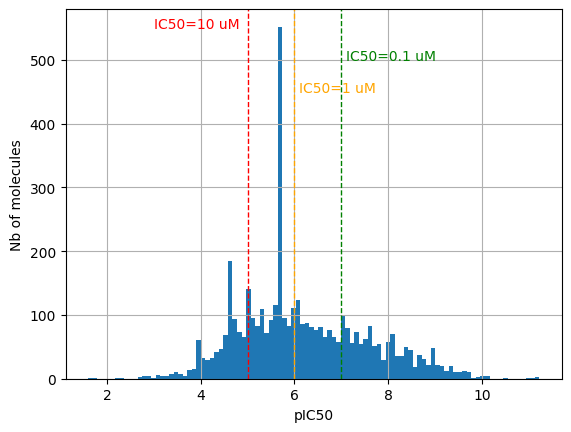

In [5]:
from matplotlib import pyplot as plt

fig = data[data_col].hist(bins=100)
plt.xlabel("pIC50")
plt.ylabel("Nb of molecules")
fig.axvline(6, color="orange", linestyle="dashed", linewidth=1)
fig.annotate("IC50=1 uM", xy=(6, 450), xytext=(6.1, 450), color="orange")
fig.axvline(7, color="green", linestyle="dashed", linewidth=1)
fig.annotate("IC50=0.1 uM ", xy=(7, 500), xytext=(7.1, 500), color="green")
fig.axvline(5, color="red", linestyle="dashed", linewidth=1)
fig.annotate("IC50=10 uM ", xy=(3, 550), xytext=(3, 550), color="red")

### Distribution in the chemical space
The screening library covers the dataset within the chemical space.

<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/lib_chemspace.png?raw=1" width="800"/>

## Molecular representation
For ML, molecules need to be converted into features/representation.
Here, we will focus on **Fingerprint** and **Molecular Graph**.

### **Morgan fingerprints ECFP**
Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. We use the implementation from RDKit which is called Morgan fingerprint.

The two most important parameters of these fingerprints are the `radius` and `fingerprint length`. The first specifies the radius of circular neighborhoods considered for each atom. The length parameter specifies the length to which the bit string representation is hashed.


<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/ecfp_generation.png?raw=1" width="800"/>

<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/ecfp_folding.png?raw=1" width="800"/>

The RDKit implementation is avalaible in [molfeat](https://molfeat.datamol.io/), which is a hub for all molecular featurizers.

In [6]:
#ecfp Fingerprints Featurization
from molfeat.trans.fp import FPVecTransformer

fp_transformer = FPVecTransformer(kind="ecfp:4", length=2048)
features = fp_transformer(data[mol_col].values)

# or use `datamol.to_fp`
# features = np.array([dm.to_fp(smi) for smi inn data[mol_col].values])

print(features)
features.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4396, 2048)

In [7]:
# get the inhibition values from ecfp
activities = data[data_col].values
activities

array([6.73, 6.8 , 8.54, ..., 6.21, 6.25, 5.8 ])

In [8]:
#maccs Fingerprints Featurization
fp_transformer_maccs = FPVecTransformer(kind="maccs")
features = fp_transformer(data[mol_col].values)
print(features)
features.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4396, 2048)

In [9]:
# get the inhibition values from maccs
activities = data[data_col].values
activities

array([6.73, 6.8 , 8.54, ..., 6.21, 6.25, 5.8 ])

In [10]:
# Avalon Fingerprints Featurization
fp_transformer_avalon = FPVecTransformer(kind="avalon")
features_avalon = fp_transformer_avalon(data[mol_col].values)
print(features)
features.shape

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4396, 2048)

In [11]:
# get the inhibition values from Avalon
activities = data[data_col].values
activities

array([6.73, 6.8 , 8.54, ..., 6.21, 6.25, 5.8 ])

Use those molecular fingerprints as features as the inputs for ML model.

<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/fp_ml.png?raw=1" width="300"/>

###  Molecular graph representation

<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/graph.png?raw=1" width="500"/>

Below we convert the smiles to pyg graph object directly using `PYGGraphTransformer` from `molfeat`.

Each graph in our dataset is encapsulated in a PyG Data object, a convient way of representing all structured data for use in Geometric Deep Learning (including graphs, point clouds, and meshes).

In [12]:
### Process smiles into `torch_geometric.Data` objects
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True)

# convert Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()
pyg_features = transformer(mols)

  0%|          | 0/4396 [00:00<?, ?it/s]

In [13]:
###molecular graph object
pyg_mol = pyg_features[0]
pyg_mol

Data(x=[43, 82], edge_index=[2, 94])

In [14]:
# Visualize the adjacent matrix of the above graph object
from torch_geometric.utils import to_dense_adj

to_dense_adj(pyg_mol.edge_index)

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]])

=> We can use pyg graph object as input for GNN modeling for inhibition prediction.

## Model training

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

We start by defining a function model_performance which evaluate a model on a **train-test split** of the data and returns measures such as `mean_squared_error`, `pearsonr` and `spearmanr` evaluated on the heldout test set. We also plot the scatter plot of the true bioactivity and predictions with a linear regression model fit.

#### Utility functions

In [15]:
from loguru import logger
import torch
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support

In [16]:
# Metrics
def pearsonr(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a pearson r correlation"""
    return stats.pearsonr(y_true, y_pred).statistic


def spearman(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a Spearman correlation"""
    return stats.spearmanr(y_true, y_pred).statistic


def model_performance(
    ml_model, test_x, test_y, threshold=6, verbose=True, reg_plot: bool = True
):
    """
    Helper function to calculate model performance

    Args
    ----------
    ml_model: model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)
    reg_plot: bool
        Scatter plot between predicion and true values.

    Returns
    -------
    tuple:
        MSE, Pearson R, Spearman, Precision, Recall and Fsocre on test set.
    """

    # Prediction class on test
    if isinstance(ml_model, RandomForestRegressor):
        test_pred = ml_model.predict(test_x)
    else:
        ml_model.eval()  # set model to evaluate mode
        test_pred = torch.cat([ml_model.predict(x) for x in test_x]).numpy().flatten()

    # Performance of model on test set
    ## regression
    mse = mean_squared_error(test_y, test_pred)
    pearsonr_score = pearsonr(test_y, test_pred)
    spearman_score = spearman(test_y, test_pred)
    ## classification
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true=test_y > threshold, y_pred=test_pred > threshold, average="binary"
    )

    if verbose:
        # Print performance results
        logger.info(f"mean_squared_error: {mse:.2f}")
        logger.info(f"pearson r: {pearsonr_score:.2f}")
        logger.info(f"spearman: {spearman_score:.2f}")
        logger.info(f"precision: {precision:.2f}")
        logger.info(f"recall: {recall:.2f}")
        logger.info(f"fscore: {fscore:.2f}")

    if reg_plot:
        plot_df = pd.DataFrame({"y_true": test_y, "y_pred": test_pred})
        sns.set_style("whitegrid")
        fig = sns.regplot(data=plot_df, x="y_true", y="y_pred")
        fig.axvline(threshold, color="orange", linestyle="dashed", linewidth=1)
        fig.axhline(threshold, color="orange", linestyle="dashed", linewidth=1)

    return mse, pearsonr_score, spearman_score, precision, recall, fscore

#### Data splitting for hit identification

<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/lib_chemspace.png?raw=1" width="800"/>

Here we create split data into train and test set. The splits will be shared with all the models.

**Scaffold splitting** is approach that identifies chemical series or scaffolds in the dataset and moving all molecules sharing one or more scaffolds to the test set. \
The **goal** is to evaluate how well a model performs on scaffolds and regions of chemical space that differ from those it was trained on.

In [17]:
from splito._scaffold_split import get_scaffold

# compute Murcko scaffolds
scaffolds = dm.utils.parallelized(
    fn=get_scaffold, inputs_list=data[mol_col].tolist(), n_jobs=-1, progress=True
)
print(
    f"There are unique {len(set(scaffolds))} scaffolds for {len(data)} molecules in the dataset."
)

  0%|          | 0/4396 [00:00<?, ?it/s]

There are unique 1777 scaffolds for 4396 molecules in the dataset.


In [18]:
# Create scaffold-base train-test split
from splito import ScaffoldSplit

spliter = ScaffoldSplit(
    smiles=data[mol_col].values, n_splits=5, test_size=0.2, random_state=111
)
train_index, test_index = next(spliter.split(features))

print("Training data size:", len(train_index))
print("Test data size:", len(test_index))

Training data size: 3355
Test data size: 1041


/usr/local/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


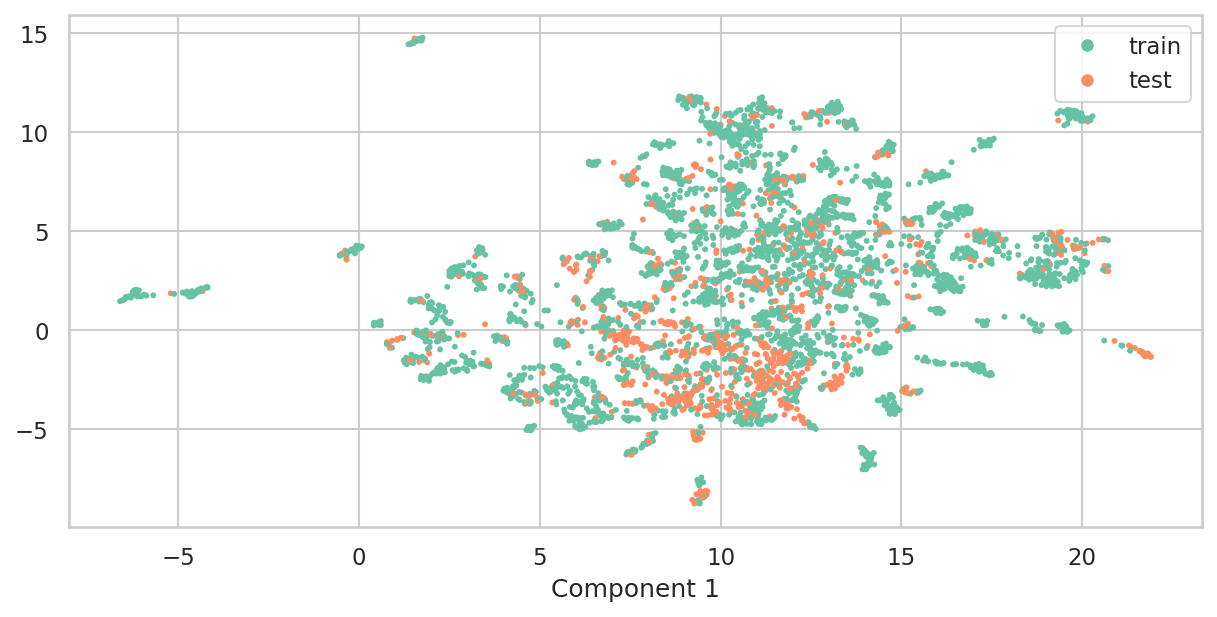

In [19]:
# Visualize their distribution within the chemical space
from chemspace_viz import visualize_chemspace

split_labels = np.full(len(features), "train", dtype=object)
split_labels[test_index] = "test"
fig = visualize_chemspace(
    X=features, y=[split_labels], metric="jaccard", min_dist=0.5, random_state=42
)

=> Diverse scaffolds in the dataset.

In [30]:
# Choice of splitting method

# In this example, we used scaffold based spliting approach. Datamol.io `splito` offers a range of other splitting method schemes.
# Now we want to adjust the project objective to discovery novel further away from the chemical space of the training set.
# We can try out a few different splitting methods, and observe the distribution and their impact on model performance.
# Eg: Checkout `splito.PerimeterSplit`.

# === ===
# spliter =
#
# === ===

#### Random forest regressor for inhibition prediction

In [20]:
# Get the features and bioactivities of the training set
train_x, train_y = features[train_index], activities[train_index]

print("Training set data shape:", train_x.shape)

Training set data shape: (3355, 2048)


In [21]:
# Define a model and train
from sklearn.ensemble import RandomForestRegressor

# Set model parameter for random forest
rf_param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "squared_error",  # cost function to be optimized for a split
}

RF_model = RandomForestRegressor(**rf_param)

In [22]:
# Fit model on single train split
RF_model.fit(train_x, train_y)

RandomForestRegressor()

2024-06-23 20:21:08.812 | INFO     | __main__:model_performance:56 - mean_squared_error: 0.99
2024-06-23 20:21:08.816 | INFO     | __main__:model_performance:57 - pearson r: 0.76
2024-06-23 20:21:08.825 | INFO     | __main__:model_performance:58 - spearman: 0.78
2024-06-23 20:21:08.826 | INFO     | __main__:model_performance:59 - precision: 0.81
2024-06-23 20:21:08.828 | INFO     | __main__:model_performance:60 - recall: 0.89
2024-06-23 20:21:08.831 | INFO     | __main__:model_performance:61 - fscore: 0.85


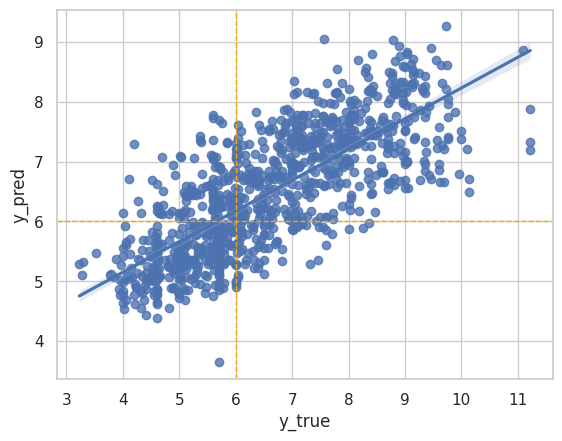

In [23]:
# Get the features and bioactivities of the test set
test_x, test_y = features[test_index], activities[test_index]

# Compute the performance and generate the plot
res = model_performance(RF_model, test_x, test_y, verbose=True, threshold=6)

In [24]:
# Dump the transformer and model to pickle file
import pickle

with open("model/rf_regressor.pkl", "wb") as fout:
    pickle.dump((fp_transformer, RF_model), fout)

#### Validation on scaffold-based splits
<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/sphx_glr_plot_cv_indices_011.png?raw=1" width="500"/>



In [25]:
# define cross validation process and metrics

from sklearn import clone


def cross_validation(
    ml_model, spliter, features, activities, verbose=True, threshold=6
):
    """
    Machine learning model training and validation in a cross-validation loop.
    """
    # Results for each of the cross-validation folds
    pearsonr_per_fold = []
    spearman_per_fold = []
    mse_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    fscore_per_fold = []

    # Loop over the folds
    for train_index, test_index in spliter.split(features):

        # clone the newly initiated model
        fold_model = clone(ml_model)

        # Training

        # Convert the fingerprint and the label to a list
        train_x = features[train_index]
        train_y = activities[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = features[test_index]
        test_y = activities[test_index]

        # Performance for each fold
        mse, pearsonr_score, spearman_score, precision, recall, fscore = (
            model_performance(
                ml_model=fold_model,
                test_x=test_x,
                test_y=test_y,
                verbose=verbose,
                threshold=threshold,
                reg_plot=False,
            )
        )

        # Save results
        mse_per_fold.append(mse)
        pearsonr_per_fold.append(pearsonr_score)
        spearman_per_fold.append(spearman_score)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        fscore_per_fold.append(fscore)

    # Print statistics of results
    print(
        f"Mean mean squared error: {np.mean(mse_per_fold):.2f} \t"
        f"and std : {np.std(mse_per_fold):.2f} \n"
        f"Mean pearsonr: {np.mean(pearsonr_per_fold):.2f} \t"
        f"and std : {np.std(pearsonr_per_fold):.2f} \n"
        f"Mean spearman: {np.mean(spearman_per_fold):.2f} \t"
        f"and std : {np.std(spearman_per_fold):.2f} \n"
        f"Mean precision: {np.mean(precision_per_fold):.2f} \t"
        f"and std : {np.std(precision_per_fold):.2f} \n"
        f"Mean recall: {np.mean(recall_per_fold):.2f} \t"
        f"and std : {np.std(recall_per_fold):.2f} \n"
        f"Mean fscore: {np.mean(fscore_per_fold):.2f} \t"
        f"and std : {np.std(fscore_per_fold):.2f} \n"
    )

    meric_per_fold = {
        "mse": mse_per_fold,
        "pearsonr": pearsonr_per_fold,
        "spearman": spearman_per_fold,
        "precision": precision_per_fold,
        "recall": recall_per_fold,
        "fscore": fscore_per_fold,
    }
    sns.boxplot(meric_per_fold, palette="pastel").set(
        title="Evaluation cross 10 splits"
    )

Mean mean squared error: 0.80 	and std : 0.13 
Mean pearsonr: 0.76 	and std : 0.03 
Mean spearman: 0.74 	and std : 0.03 
Mean precision: 0.80 	and std : 0.03 
Mean recall: 0.82 	and std : 0.05 
Mean fscore: 0.81 	and std : 0.04 



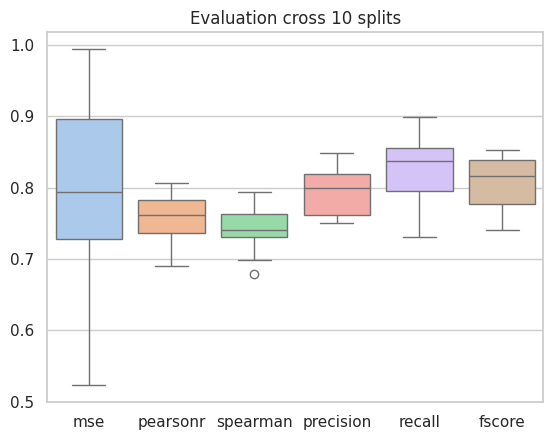

In [26]:
spliter = ScaffoldSplit(
    smiles=data[mol_col].values, n_splits=10, test_size=0.2, random_state=111
)
cross_validation(
    ml_model=RandomForestRegressor(**rf_param),
    spliter=spliter,
    features=features,
    activities=activities,
    threshold=6,
    verbose=False,
)

<!-- <img src="figures/validation.png" width="500"/> -->



#### Graph neural network for inhibition prediction

<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/gnn_ml.png?raw=1" width="800"/>

Here we train a graph neural network model with 3 convolutional layers and a followed by a linear transformer for final output.

In [46]:
import torch
from gnn import GCNModel

# Define the graph model
# Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create network and send to the device memory
gnn_model = GCNModel(
    in_channels=transformer(mols[0])[0].x.shape[1],
    hidden_channels=128,
    out_channels=1,
    num_layers=3,
    is_reg=True,
).to(device)

# Use Adam optimizer
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001, weight_decay=0)

# Define the loss function
loss_fn = torch.nn.MSELoss()

In [47]:
# Display the GNN model
gnn_model

GCNModel(
  (conv_layers): ModuleList(
    (0): GCNConv(82, 128)
    (1-3): 3 x GCNConv(128, 128)
  )
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [48]:
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = np.array(dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True))

# converT Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()

train_set = []
for index in train_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y = torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    train_set.append(pyg_data)

test_set = []
for index in test_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y = torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    test_set.append(pyg_data)

  0%|          | 0/4396 [00:00<?, ?it/s]

Batching graphs can often be a tedious and intricate process. Fortunately, PyG simplifies this task significantly. With a list of Data objects, we can effortlessly batch them into a PyG Batch object and also unbatch them back into individual graphs. Moreover, for straightforward scenarios like ours, the PyG DataLoader object takes care of all the batching automatically.

In [49]:
# Create dataloaders with batch size 8
from torch_geometric.loader import DataLoader

batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Training loop ...

In [50]:
from loguru import logger
from tqdm import tqdm

num_epoch = 5

# train model
# set model to training mode
gnn_model.train()

# run for epochs of training
for epoch in range(num_epoch):
    sum_loss = 0  # used to compute average loss in an epoch

    # go over each training batches
    for batch in tqdm(train_loader):
        batch = batch.to(device)  # send data to device
        optimizer.zero_grad()  # zero gradients

        # #evaluate data point
        out = gnn_model(batch)
        loss = loss_fn(out, batch.y)  # compute the loss
        sum_loss += float(loss)  # Add loss value to aggregate loss

        # compute gradients
        loss.backward()
        # apply optimization

        optimizer.step()
    logger.info(
        "Epoch: {:03d}, Average loss: {:.5f}".format(epoch, sum_loss / len(train_set))
    )

  0%|          | 0/420 [00:00<?, ?it/s]/usr/local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 413/420 [00:03<00:00, 92.75it/s]/usr/local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 420/420 [00:03<00:00, 109.29it/s]
2024-06-23 21:33:31.830 | INFO     | __main__:<cell line: 11>:29 - Epoch: 000, Average loss: 0.29130
100%|██████████| 420/420 [00:04<00:00, 90.23it/s] 
2024-06-23 21:33:36.496

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
2024-06-23 21:34:11.407 | INFO     | __main__:model_performance:56 - mean_squared_error: 36.65
2024-06-23 21:34:11.410 | INFO     | __main__:model_performance:57 - pearson r: 0.21
2024-06-23 21:34:11.412 | INFO     | __main__:model_performance:58 - spearman: 0.22
2024-06-23 21:34:11.415 | INFO     | __main__:model_performance:59 - precision: 0.00
2024-06-23 21:34:11.419 | INFO     | __main__:model_performance:60 - recall: 0.00
2024-06-23 21:34:11.421 | INFO     | __main__:model_performance:61 - fscore: 0.00


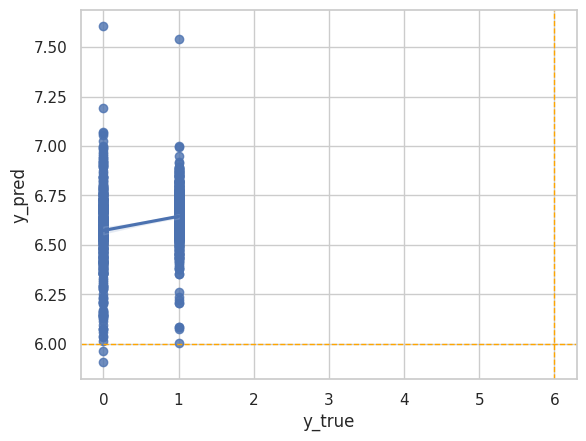

In [51]:
# Compute the performance and generate the plot

res = model_performance(gnn_model, test_loader, test_y, verbose=True, threshold=6)

#### Hyperparameter tuning

Hyperparameter tuning is the process of selecting the best set of parameters for a machine learning model and the dataset to improve the performance.

Efficient HP tuning can be performed by using frameworks, such as **Optuna** and **Weights & Biases sweep**.

=> train/validation/test set

<img src="https://github.com/valence-labs/mtl_summer_school_2024/blob/main/Lab1/figures/HP_tuning.png?raw=1" width="800"/>

Instead of a regressor, here we try to train the classifiers, and predict the inhibition class (inhbitor, non inhibitor) of the dataset.

In [52]:
# Convert regression labels to classification labels
threshold = 6  # Define your threshold
activities_class = (activities >= threshold).astype(int)  # 1 if inhibitor, 0 if non-inhibitor

In [53]:
# Random Forest Classifier for inhibition prediction
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Get the features and bioactivities of the training set
train_x, train_y = features[train_index], activities_class[train_index]

print("Training set data shape:", train_x.shape)

# Define a model and train
rf_param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "gini",  # cost function to be optimized for a split
}

RF_model = RandomForestClassifier(**rf_param)

# Fit model on single train split
RF_model.fit(train_x, train_y)

# Get the features and bioactivities of the test set
test_x, test_y = features[test_index], activities_class[test_index]

# Compute the performance
predictions = RF_model.predict(test_x)
accuracy = accuracy_score(test_y, predictions)
precision = precision_score(test_y, predictions)
recall = recall_score(test_y, predictions)
f1 = f1_score(test_y, predictions)
conf_matrix = confusion_matrix(test_y, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:\n", conf_matrix)

Training set data shape: (3355, 2048)
Accuracy: 0.82
Precision: 0.83
Recall: 0.88
F1 Score: 0.85
Confusion Matrix:
 [[326 111]
 [ 72 532]]


In [54]:
from sklearn import clone

def cross_validation_classifier(
    ml_model, spliter, features, activities_class, verbose=True
):
    """
    Machine learning model training and validation in a cross-validation loop.
    """
    # Results for each of the cross-validation folds
    accuracy_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    f1_per_fold = []

    # Loop over the folds
    for train_index, test_index in spliter.split(features):
        # clone the newly initiated model
        fold_model = clone(ml_model)
        # Training
        train_x = features[train_index]
        train_y = activities_class[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing
        test_x = features[test_index]
        test_y = activities_class[test_index]

        # Performance for each fold
        predictions = fold_model.predict(test_x)
        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions)
        recall = recall_score(test_y, predictions)
        f1 = f1_score(test_y, predictions)

        # Save results
        accuracy_per_fold.append(accuracy)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        f1_per_fold.append(f1)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(accuracy_per_fold):.2f} \t"
        f"and std : {np.std(accuracy_per_fold):.2f} \n"
        f"Mean precision: {np.mean(precision_per_fold):.2f} \t"
        f"and std : {np.std(precision_per_fold):.2f} \n"
        f"Mean recall: {np.mean(recall_per_fold):.2f} \t"
        f"and std : {np.std(recall_per_fold):.2f} \n"
        f"Mean f1: {np.mean(f1_per_fold):.2f} \t"
        f"and std : {np.std(f1_per_fold):.2f} \n"
    )

spliter = ScaffoldSplit(
    smiles=data[mol_col].values, n_splits=10, test_size=0.2, random_state=111
)
cross_validation_classifier(
    ml_model=RandomForestClassifier(**rf_param),
    spliter=spliter,
    features=features,
    activities_class=activities_class,
    verbose=False,
)

Mean accuracy: 0.81 	and std : 0.03 
Mean precision: 0.82 	and std : 0.04 
Mean recall: 0.80 	and std : 0.05 
Mean f1: 0.81 	and std : 0.04 



In [55]:
import torch
from gnn import GCNModel

# Define the graph model for classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gnn_model = GCNModel(
    in_channels=transformer(mols[0])[0].x.shape[1],
    hidden_channels=128,
    out_channels=2,  # Two output channels for binary classification
    num_layers=3,
    is_reg=False,  # Indicating that this is a classifier
).to(device)

# Use Adam optimizer
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001, weight_decay=0)

# Define the loss function for classification
loss_fn = torch.nn.CrossEntropyLoss()

# Display the GNN model
gnn_model

# Prepare data for the GNN classifier
from molfeat.trans.graph.adj import PYGGraphTransformer

mols = np.array(dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True))
transformer = PYGGraphTransformer()

train_set = []
for index in train_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y = torch.from_numpy(np.array([activities_class[index]])).to(torch.long)
    train_set.append(pyg_data)

test_set = []
for index in test_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y = torch.from_numpy(np.array([activities_class[index]])).to(torch.long)
    test_set.append(pyg_data)

from torch_geometric.loader import DataLoader

batch_size = 8
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

from loguru import logger
from tqdm import tqdm

num_epoch = 5

# Train the GNN classifier
gnn_model.train()

for epoch in range(num_epoch):
    sum_loss = 0

    for batch in tqdm(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = gnn_model(batch)
        loss = loss_fn(out, batch.y)
        sum_loss += float(loss)
        loss.backward()
        optimizer.step()

    logger.info(
        "Epoch: {:03d}, Average loss: {:.5f}".format(epoch, sum_loss / len(train_set))
    )

# Evaluate the GNN classifier
gnn_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = gnn_model(batch)
        _, predicted = torch.max(outputs.data, 1)
        total += batch.y.size(0)
        correct += (predicted == batch.y).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy of the GNN on the test set: {accuracy:.2f}%")

  0%|          | 0/4396 [00:00<?, ?it/s]

100%|██████████| 420/420 [00:04<00:00, 91.35it/s]
2024-06-23 21:36:57.882 | INFO     | __main__:<cell line: 56>:68 - Epoch: 000, Average loss: 0.07049
100%|██████████| 420/420 [00:04<00:00, 97.10it/s] 
2024-06-23 21:37:02.218 | INFO     | __main__:<cell line: 56>:68 - Epoch: 001, Average loss: 0.06230
100%|██████████| 420/420 [00:03<00:00, 110.13it/s]
2024-06-23 21:37:06.045 | INFO     | __main__:<cell line: 56>:68 - Epoch: 002, Average loss: 0.06052
100%|██████████| 420/420 [00:03<00:00, 112.65it/s]
2024-06-23 21:37:09.782 | INFO     | __main__:<cell line: 56>:68 - Epoch: 003, Average loss: 0.05798
100%|██████████| 420/420 [00:04<00:00, 88.89it/s]
2024-06-23 21:37:14.521 | INFO     | __main__:<cell line: 56>:68 - Epoch: 004, Average loss: 0.05655


Accuracy of the GNN on the test set: 78.19%


In [ ]:
#Graph representation learning with graphium

# Instead of `pyg`, we can use Datamol.io `graphium` to train graph-based model.

!pip install graphium

import graphium
from graphium.data import MoleculeDataset
from graphium.data.smiles import smiles_to_dataset
from graphium.utils import Trainer
from graphium.config import GNNConfig

# Convert SMILES to Graphium Dataset
smiles_list = data[mol_col].tolist()
labels = activities_class.tolist()  # Use the classification labels

# Create Graphium dataset
dataset = smiles_to_dataset(smiles_list, labels)

# Define GNN configuration
gnn_config = GNNConfig(
    model_name="GraphConv",
    input_dim=dataset.num_node_features,
    hidden_dim=128,
    output_dim=2,  # Binary classification
    num_layers=3,
    dropout=0.2,
    batch_size=8,
    epochs=5,
    learning_rate=0.001
)

# Initialize GNN model with the configuration
gnn_model = graphium.models.GNN(config=gnn_config)

# Train the model using the Trainer class
trainer = Trainer(
    model=gnn_model,
    dataset=dataset,
    config=gnn_config
)
trainer.train()

# Evaluate the model
test_accuracy = trainer.evaluate()
print(f"Accuracy of the Graphium GNN model on the test set: {test_accuracy:.2f}%")

# Virtual screening

We have successfully trained several models. The next step is to use these models to predict binding affinity with an unknown screening dataset to discover novel potential EGFR inhibitors.

Here we will perform virtual screening on a smaller library of 24,000 compounds specifically designed for discovering novel kinase ATP pocket binders.

In [56]:
import pickle
import numpy as np
import datamol as dm

In [57]:
# load commercial screening library
lib_path = "data/Enamine_Hinge_Binders_Library_plated_24000cmds_20210316.sdf"
lib_df = dm.read_sdf(lib_path, as_df=True, mol_column="mol")

#### Library statistics

In [58]:
lib_df.head(5)

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7a4beffdc350>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf06acba0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf06acc10>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf06acb30>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf06accf0>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3


In [59]:
lib_df.describe(include="all")

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
count,24000,24000,24000,24000,24000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
unique,24000,24000,24000,300,80,NaN,NaN,NaN,NaN,NaN
top,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7a4beffdc350>,Z57603637,1252574-R-230,A02,NaN,NaN,NaN,NaN,NaN
freq,1,1,1,80,300,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,348.377242,2.339357,1.406417,75.599830,4.600583
std,NaN,NaN,NaN,NaN,NaN,53.655375,1.339740,0.738477,19.544894,1.584347
min,NaN,NaN,NaN,NaN,NaN,177.226000,-2.841000,0.000000,19.370000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,312.409000,1.418000,1.000000,61.880000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,341.336000,2.370000,1.000000,74.610000,5.000000
75%,NaN,NaN,NaN,NaN,NaN,382.502250,3.250000,2.000000,87.910000,6.000000


### Load the pre-trained models and transformers

In [60]:
# load the fingerprint transformer and random forest model for EGFR binding affinity
with open("model/rf_regressor.pkl", "rb") as f:
    fp_transformer, rf_model = pickle.load(f)

### Scoring the compounds library with the predictive models

Here we begin by defining a scoring function that converts the molecular SMILES to feature inputs for the predictive models and predicts the pIC50 values.

In [61]:
import torch
from gnn import GCNModel


def score(mol, transformer, model, is_reg=True):
    try:
        # compute the molecular features
        feat = transformer(mol)
        if isinstance(model, GCNModel):
            feat = transformer.get_collate_fn()(transformer(mol))[0]
        # score the molecule
        if is_reg:
            score = model.predict(feat)
        else:
            score = model.predict_proba(feat)[:, 1]
        if torch.is_tensor(score):
            score = score.flatten().numpy()
    except Exception as e:
        score = None
    return score

### Make predictions on pIC50

In [66]:
import datamol as dm
import pandas as pd
import pickle

# Define a function to load the model and score a batch of molecules
def score_molecule_batch(smiles_batch, fp_transformer, rf_model):
    predictions = []
    for smiles in smiles_batch:
        mol = dm.to_mol(smiles)
        features = fp_transformer(mol).reshape(1, -1)  # Flatten the features to 2D
        prediction = rf_model.predict(features)[0]
        predictions.append(prediction)
    return predictions

# Load the model and transformer
with open("model/rf_regressor.pkl", "rb") as f:
    fp_transformer, rf_model = pickle.load(f)

# Parallelize the scoring
lib_df["rf_preds_pIC50"] = dm.utils.parallelized_with_batches(
    fn=lambda batch: score_molecule_batch(batch, fp_transformer, rf_model),
    inputs_list=lib_df.smiles.values,
    batch_size=1000,
    progress=True,
)

  0%|          | 0/24 [00:00<?, ?it/s]

In [62]:
# Parallelize the scoring
lib_df["rf_preds_pIC50"] = dm.utils.parallelized_with_batches(
    fn=lambda mol: score(mol, fp_transformer, rf_model),
    inputs_list=lib_df.smiles.values,
    batch_size=1000,
    progress=True,
)

  0%|          | 0/24 [00:00<?, ?it/s]

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [67]:
lib_df.head(5)

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds,rf_preds_pIC50
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x7a4beffdc350>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0,5.084167
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf06acba0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2,5.231200
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf06acc10>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0,5.549900
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf06acb30>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2,5.080400
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf06accf0>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3,4.876000


## Compound prioritization

Number of compounds having predicted pIC50 greater than 6:  1747
Number of compounds having predicted pIC50 greater than 7:  26


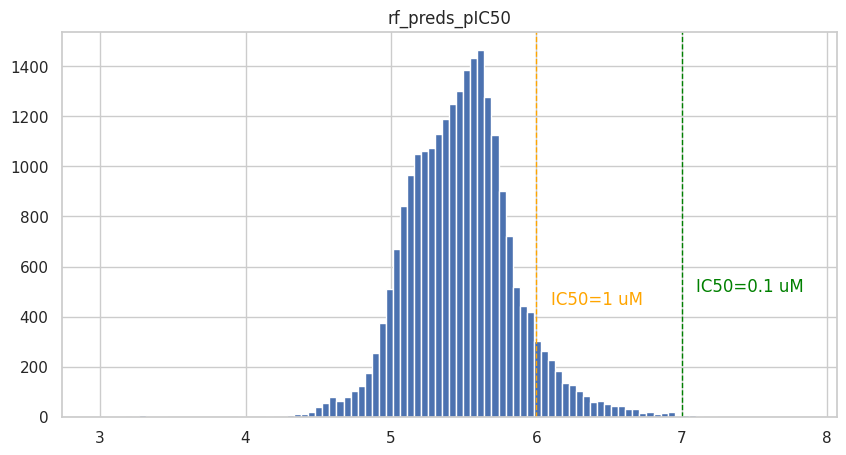

In [68]:
fig = lib_df[["rf_preds_pIC50"]].hist(bins=100, figsize=(10, 5))[0][0]
fig.axvline(6, color="orange", linestyle="dashed", linewidth=1)
fig.annotate("IC50=0.1 uM ", xy=(7, 500), xytext=(7.1, 500), color="green")
fig.axvline(7, color="green", linestyle="dashed", linewidth=1)
fig.annotate("IC50=1 uM", xy=(6, 450), xytext=(6.1, 450), color="orange")

print(
    "Number of compounds having predicted pIC50 greater than 6: ",
    lib_df["rf_preds_pIC50"].gt(6).sum(),
)
print(
    "Number of compounds having predicted pIC50 greater than 7: ",
    lib_df["rf_preds_pIC50"].gt(7).sum(),
)

### Filter molecules by predicted pIC50 values

In [69]:
lib_df_selected = lib_df.query("rf_preds_pIC50 > 6.5")
len(lib_df_selected)

274

#### Filter molecules by the desired molecular weight 280 ~ 400 Dalton

In [70]:
lib_df_selected = lib_df_selected[lib_df_selected["MW (desalted)"].between(280, 400)]
len(lib_df_selected)

215

### Exclude the possible repeated molecules between training set and prioritized set
We have to make sure that non of the prioritiezed compounds are already in the training set. \
Therefore, we compare the `unique_id` of molecules, and exlude the repeated molecules from the prioritized set.

In [71]:
import pandas as pd

# Compute the unique id
data_train = pd.read_csv("data/egfr_pIC50.csv")
data_train["uid"] = data_train["MOL_smiles"].apply(
    lambda smi: dm.unique_id(dm.to_mol(smi))
)
lib_df_selected.loc[:, "uid"] = lib_df_selected["mol"].apply(dm.unique_id).values


# Exclude the molecules in training set from the prioritized set
lib_df_selected = lib_df_selected.query("uid not in @data_train.uid")

len(lib_df_selected )

214

Number of compounds having predicted pIC50 greater than 6.5:  214
Number of compounds having predicted pIC50 greater than 7:  21


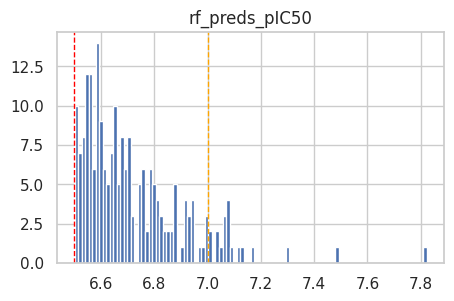

In [72]:
fig = lib_df_selected[["rf_preds_pIC50"]].hist(bins=100, figsize=(5,3))[0][0]
fig.axvline(6.5, color="red", linestyle="dashed", linewidth=1)
fig.axvline(7, color="orange", linestyle="dashed", linewidth=1)
print(
    "Number of compounds having predicted pIC50 greater than 6.5: ",
    lib_df_selected["rf_preds_pIC50"].gt(6).sum(),
)
print(
    "Number of compounds having predicted pIC50 greater than 7: ",
    lib_df_selected["rf_preds_pIC50"].gt(7).sum(),
)

In [ ]:
# Exercise 4:  Multi-Objective Optimization

# This tutorial only uses the egfr binding affinity model for compound priotirization.
# In real drug design programs, compounds often are optimized for multiple objectives.
# Please use toy model at `data/toy_classifier.pkl` as second objective (optimize for label 1) and rank the compounds.
# You can use the ranking algorithm `MOORA` which is available at script `moora.py`.

# === YOUR CODE GOES HERE ===

# === END ===

### Distribution in chemical space
Now let's check the distribution of training set and prioritized molecules in chemical space.

/usr/local/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


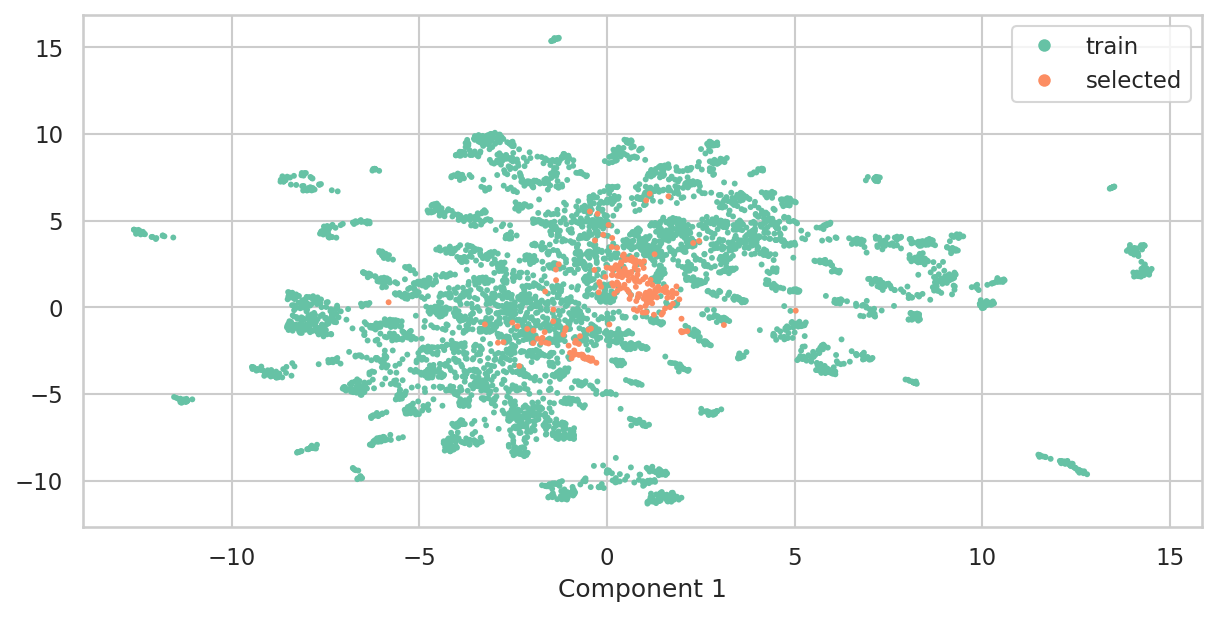

In [73]:
from chemspace_viz import visualize_chemspace

# compute the molecule features
train_feat = fp_transformer(data_train["MOL_smiles"])
lib_feat = fp_transformer(lib_df_selected["mol"])

fig = visualize_chemspace(
    X=np.concatenate([train_feat, lib_feat]),
    y=np.array(["train"] * len(train_feat) + ["selected"] * len(lib_feat)),
    metric="jaccard",
    min_dist=0.5,
    random_state=42,
)

The prioritized molecules (highlighted in orange) are mainly distributed in one cluster in the middle.
Now we can use the predicted `pIC50` value to rank order the screened compounds and select a diverse set of these molecules for furture steps.

#### Diverse pick of selected molecules
In drug discovery and development, selecting a diverse set of molecules is a critical step to ensure a comprehensive exploration of chemical space. This diversity maximizes the chances of identifying promising lead compounds with varying structural and functional characteristics.

In [74]:
# Rank the molecules by pIC50
lib_df_selected = lib_df_selected.sort_values(
    by="rf_preds_pIC50", ascending=False
).reset_index(drop=True)

In [75]:
# Select 100 most diverse molecules from the set
picked_index, _ = dm.pick_diverse(
    mols=lib_df_selected.mol.values, npick=100, initial_picks=range(5)
)
lib_df_selected = lib_df_selected.iloc[picked_index]

/usr/local/lib/python3.10/site-packages/umap/umap_.py:1879: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/usr/local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


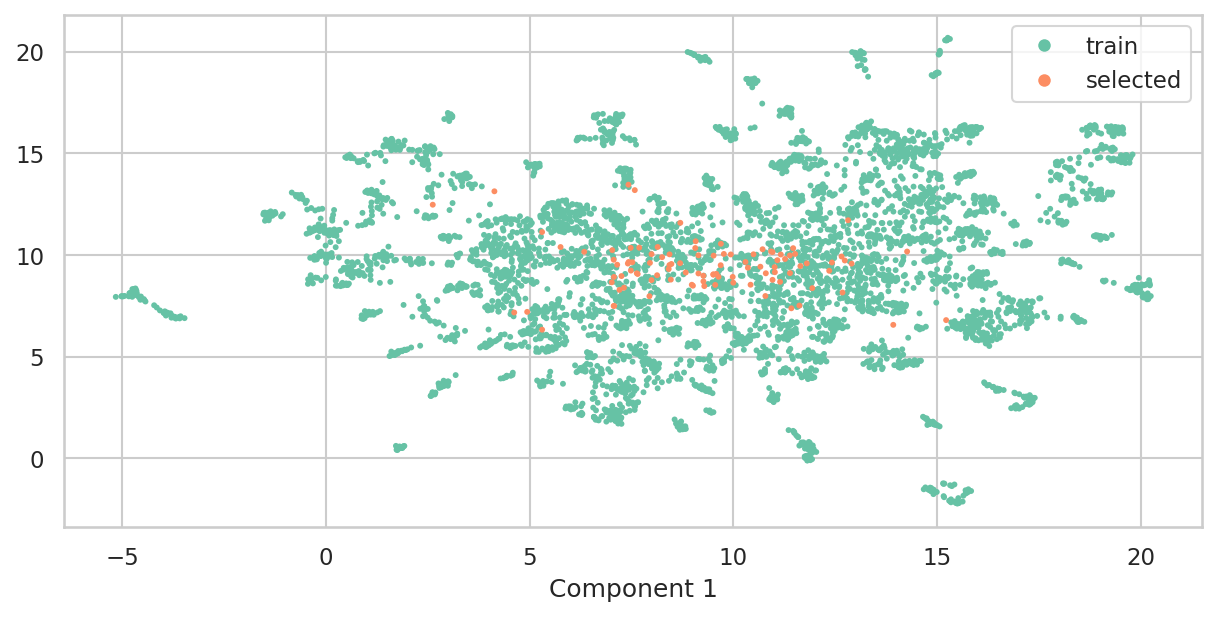

In [76]:
picked_feat = fp_transformer(lib_df_selected["mol"])
fig = visualize_chemspace(
    X=np.concatenate([train_feat, picked_feat]),
    y=np.array(["train"] * len(train_feat) + ["selected"] * len(picked_feat)),
    metric="jaccard",
    min_dist=0.5,
    random_state=42,
)

In [77]:
lib_df_selected

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds,rf_preds_pIC50,uid
0,Fc1ccc(-c2cc3ncnc(Nc4ccc5c(c4)OCCO5)c3s2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf952c430>,Z31192075,1252574-R-229,D07,379.407,5.966,1,56.27,3,7.823100,0e6f90b5204e2599204bee49ea621186
1,COCCOc1ccc(Nc2ncnc3c(F)cccc23)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x7a4bf8ed0c80>,Z1874024228,1252574-R-250,D08,347.771,4.397,1,56.27,6,7.483400,78d9f587281828fa66afb12f25dc55b4
2,COCCOc1ccc(Nc2ncnc3cccc(F)c23)cc1F,<rdkit.Chem.rdchem.Mol object at 0x7a4bf906c200>,Z1182657406,1252574-R-289,H11,331.317,3.857,1,56.27,6,7.301333,9e6dba316eff2f2dd90a426d2ef22a2f
3,CN1C(=O)C(C)(C)COc2ccc(Nc3ncnc4[nH]ncc34)cc21,<rdkit.Chem.rdchem.Mol object at 0x7a4bf8e605f0>,Z2976158695,1252574-R-225,F04,338.364,2.806,2,96.03,2,7.165200,62798735c11dd3c3eb8415ecfcb7bec8
4,CN1C(=O)C(C)(C)COc2ccc(Nc3ncnc4[nH]ccc34)cc21,<rdkit.Chem.rdchem.Mol object at 0x7a4bf8e60660>,Z2976158885,1252574-R-256,B10,337.376,3.217,2,83.14,2,7.126500,596d7af0222224b72cc48c5a986a7afc
...,...,...,...,...,...,...,...,...,...,...,...,...
98,CC(C)(C)OC(=O)[C@H](Cc1ccccc1)Nc1ncnc2c1cnn2C(...,<rdkit.Chem.rdchem.Mol object at 0x7a4bf8fee810>,Z1590659308,1252574-R-024,H06,395.498,4.306,1,81.93,8,6.681900,c9e1ce82282f14b278a8abd37f5a0a6a
181,CC(Nc1ncnc2cccc(F)c12)c1cccc(C#N)c1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf8f6d620>,Z1281734394,1252574-R-115,A02,292.310,3.253,1,61.60,3,6.549308,f6cfaebc35234a4259c39a00998ed4d0
212,c1ccc(Cn2ncc3c2CCCC3Nc2ncnc3[nH]ccc23)cc1,<rdkit.Chem.rdchem.Mol object at 0x7a4bf90a9930>,Z991905898,1252574-R-052,B11,344.413,3.482,2,71.42,4,6.501300,07c03270042ec5fc4c9e185c183616c2
74,COc1cc2c(NC(CN3CCCC3=O)c3ccccc3)ncnc2cc1F,<rdkit.Chem.rdchem.Mol object at 0x7a4bf8f32340>,Z1695667667,1252574-R-048,H10,380.415,3.303,1,67.35,6,6.743100,d517c06a30e1946f3e450e3c679026f2


Now we visualize the picked molecules.

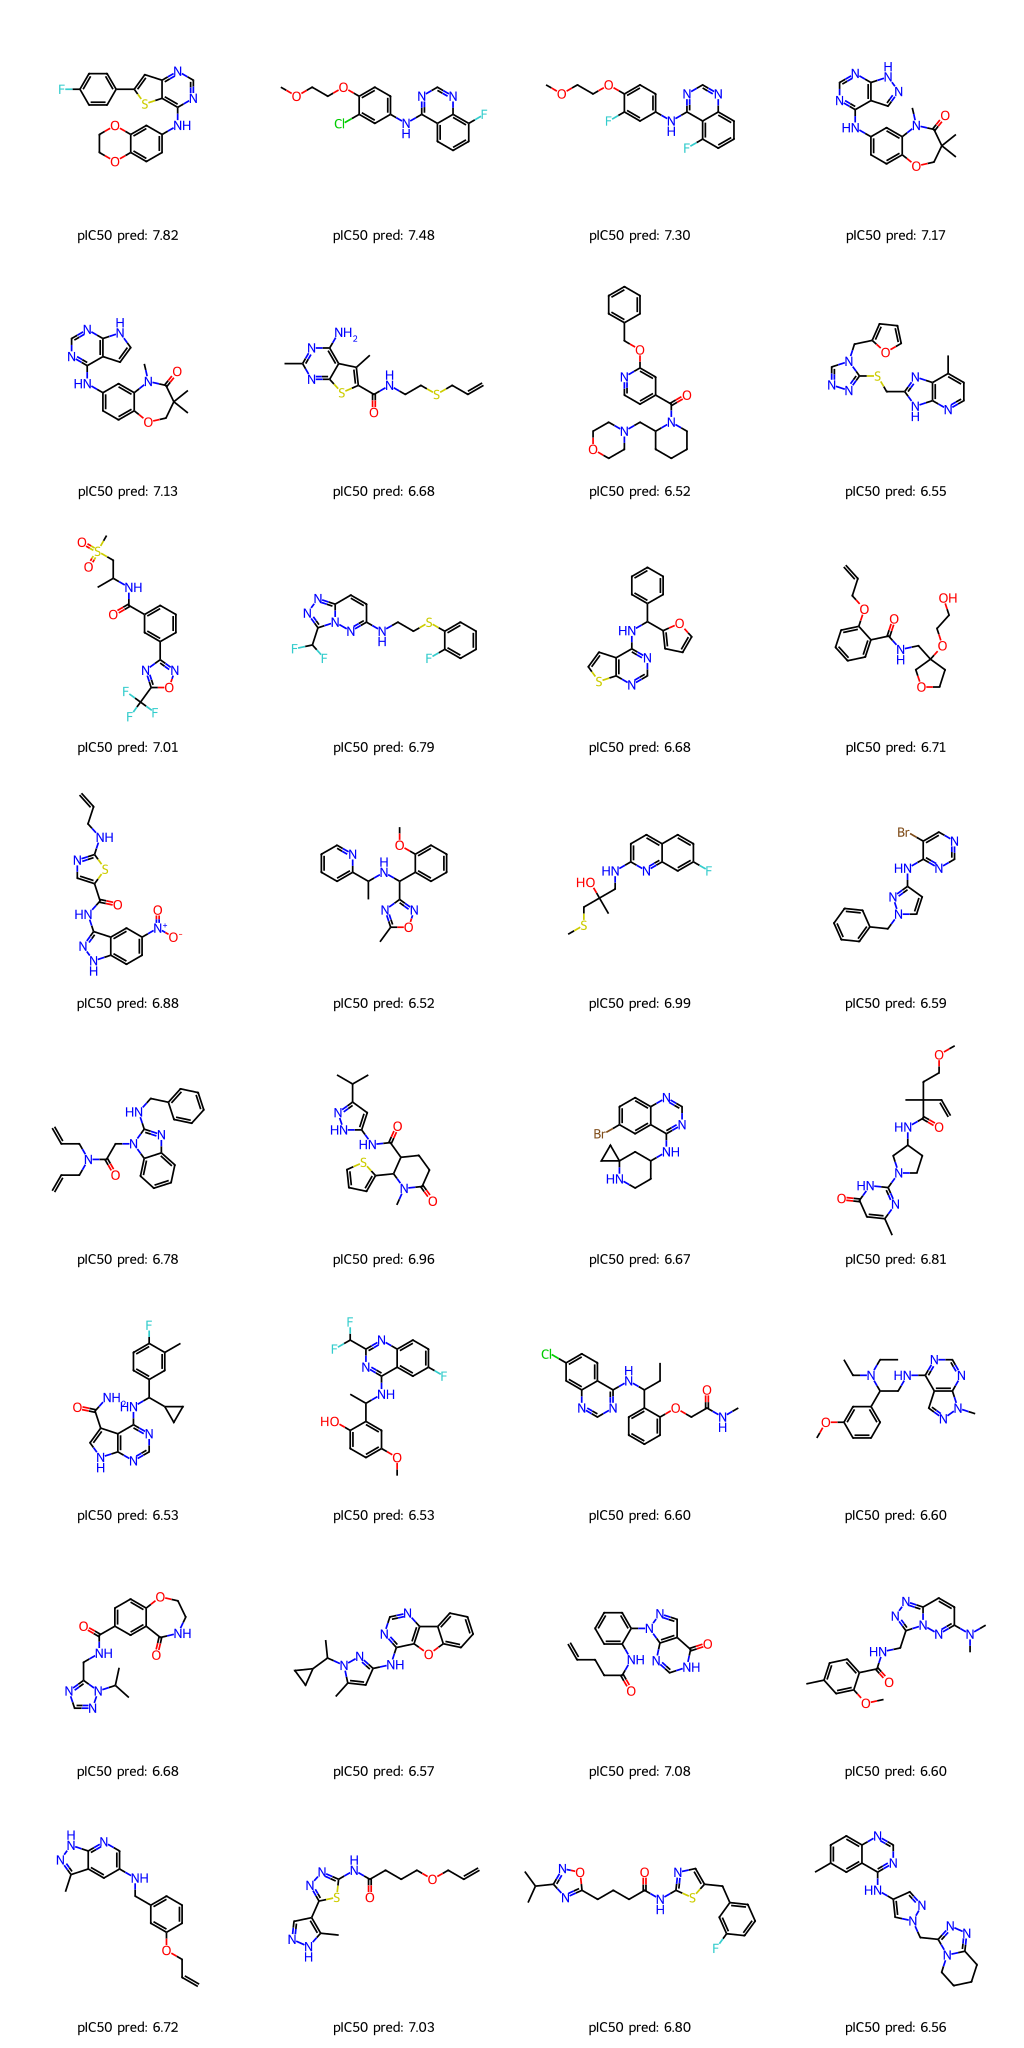

In [78]:
legends = (
    lib_df_selected["rf_preds_pIC50"]
    .apply(lambda x: "pIC50 pred: {:,.2f}".format(x))
    .tolist()
)
dm.to_image(lib_df_selected.mol.tolist(), legends=legends)


Our models could be used to rank the compounds and then further study those with the highest predicted binding affinity.


In [79]:
# Export the selected molecules
import os

os.makedirs("output", exist_ok=True)
lib_df_selected.drop(columns="mol").to_csv("output/picked100mols.csv", index=False)

In [ ]:
### Here the molecules were filtered only by the predicted inhibition pIC50 values and molecular weight.
### Often medchem filters are applied to prioritize molecules which are more druglike.
### Check out https://github.com/datamol-io/medchem